# Melt model examples

This notebook explains the melt models in the icemeltmodels module and demonstrates how to use the implementation.

## Motivation for these models

Numerical models of ice sheets and oceans are unable to resolve the fine details of the turbulent mixing at the ice-ocean boundary. Of particular interest are the heat and salt fluxes associated with melting or freezing of the ice.

## Origin of the models

The four models currently implemented are based on the two- and three-equation formulations presented in Jenkins et al. (2010).

The basic idea is that freezing water to form ice releases latent heat, and conversely, melting ice to form water requires taking in heat from the environment. The latent heat abduction from the environment must be balanced by the heat fluxes in from the (warmer) ocean and out into the (colder) ice.
We can write this down as the equation
$$\rho_i L_i \dot{m} = F_o + F_i$$
where $\rho_i$ is the density of ice, $L_i$ is the latent heat of ice, $\dot{m}$ is the melt rate, $F_o$ is the heat flux from the ocean to the ice-ocean interface, and $F_i$ is the flux from the ice to the ice-ocean interface.

Note that $\dot{m}$ has dimensions $[L T^{-1}]$, i.e. it has the same dimensions as a velocity. This is because the melt rate is conventionally defined as the rate at which the ice-ocean interface moves into the ice, in the direction normal to the surface.

Thus (by dimensional analysis) the heat fluxes on the right hand side have dimensions of energy per unit area per unit time, as expected. Note also that we expect $F_o > 0$ as the ocean is warmer than the ice-ocean interface (which is at the freezing temperature), so heat flows from the ocean into the ice-ocean interface, whereas we expect $F_i < 0$ because we expect the ice in the interior to be colder than the ice at the boundary (though this is not necessarily the case), hence the heat flux should be from the boundary to the ice interior, that is, away from the ice-ocean interface.

The competition between $F_o$ and $F_i$ determines whether we have melting $\dot{m} > 0$ or freezing $\dot{m} < 0$. Explicitly, melting occurs if $F_o + F_i > 0$, whereas freezing occurs if $F_o + F_i < 0$. Since we expect $F_o > 0$ and $F_i < 0$, this is equivalent to saying that melting occurs when ocean heat flux dominates, whereas freezing occurs when ocean heat flux is small compared to the heat flux to the ice.

The problem is that typical ocean models have insufficient resolution to resolve the turbulent dynamics in the boundary layer near the ice-ocean interface, let alone the very narrow (millimetre-scale) viscous interfacial sublayer that exists right at the interface. A further complication is that the salinity depresses the freezing temperature, and the salinity right at the ice-ocean interface is governed by the gradients in the haline boundary layer, which, due to the very large Schmidt number of seawater ($\nu / D \approx 700$) is even narrower than the viscous interfacial sublayer. So there is no hope of resolving the detailed thermodynamic conditions at the ice-ocean interface in a regional or global scale ocean model. 

Moreover, unless the ocean model is coupled to an ice sheet model, one has to estimate the conductive heat fluxes within the ice by some ad hoc method. 

This means that we have to use parameterisations for the turbulent oceanic heat flux $F_o$ and the conductive ice heat flux $F_i$. The four melt models implemented in this module differ in their representation of these terms.

References:
Jenkins et al., 2010. Observation and Parameterization of Ablation at the Base of Ronne Ice Shelf, Antarctica. Journal of Physical Oceanography. https://doi.org/10.1175/2010JPO4317.1

## Two Equation Melt Model Neglecting Conduction

This model neglects conduction of heat into the ice, i.e. set $F_i = 0$ (so this model can only predict melting, not freezing).

In this model, the ocean heat flux $F_o$ is assumed to be proportional to the resolved free-stream current speed and the ocean thermal forcing. 
The free-stream current speed is the magnitude of the velocity of the ocean water at the nearest grid cell from the ice-ocean interface, which for a typical ocean model will be outside of the turbulent boundary layer. The ocean thermal forcing is the temperature difference between the ocean at this grid cell and the ocean at the ice-ocean boundary, which will be at the freezing temperature. The constant of proportionality is called the transfer coefficient; it tries to account for the effects of temperature and salinity fluxes.

The freezing temperature itself depends on the local salinity and pressure. In this model, we calculate the freezing temperature using the salinity (and pressure) from the adjacent ocean grid cell.

The model is thus
$$\rho_i L_i \dot{m} = \rho_w c_w \gamma_{TS} U (T_w - T_f)$$
$$T_f = \lambda_1 S_w + \lambda_2 + \lambda_3 P_b$$
where $\rho_w$ is the density of seawater, $c_w$ is the heat capacity of seawater, $\gamma_{TS}$ is the transfer coefficient (described above), $U$ is the ocean current velocity magnitude outside the turbulent boundary layer, $T_w$ is the ocean water temperature outside the turbulent boundary layer, $T_f$ is the freezing temperature (calculated by the second equation), $S_w$ is the ocean salinity outside the turbulent boundary layer, $P_b$ is the pressure at the ice-ocean boundary, $\lambda_1$ is the liquidus slope, $\lambda_2$ is the liquidus intercept, and $\lambda_3$ is the liquidus pressure coefficient.

The first of these equations is just the heat conservation equation from earlier, with $F_i=0$ and $F_o$ parameterised by the expression on the right hand side. The second equation is a linear approximation for the freezing temperature of ocean water.

The physical properties $\rho_i$, $L_i$, etc. are known in principle (e.g. see the values given in Jenkins et al. 2010, which are the default values in this implementation). The ocean flow parameters outside the turbulent boundary layer, $U$, $T_w$, $S_w$, and $P_b$ are given by the ocean model at the grid cells adjacent to the ice-ocean interface. So there are only two unknowns: $T_f$ and $\dot{m}$. In this case, we can easily find the melt rate $\dot{m}$ by first computing $T_f$ using the second equation and then $\dot{m}$ using the first equation.

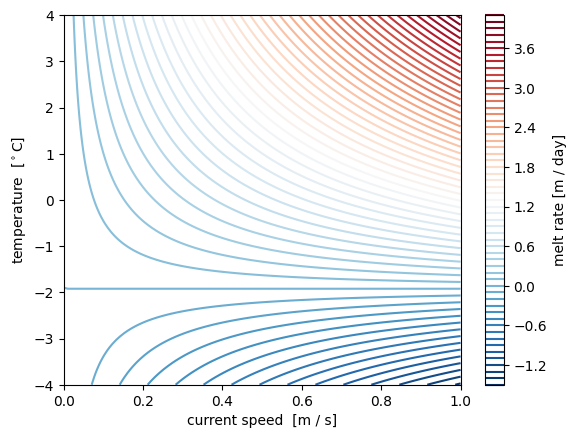

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icemeltmodels import TwoEquationMeltModelNeglectingConduction

S_w = 35 # g / kg
P_b = 0  # surface pressure
temperatures = np.linspace(-4, 4, 100)
speeds = np.linspace(0, 1, 100)
U, T_w = np.meshgrid(speeds, temperatures)
Z = TwoEquationMeltModelNeglectingConduction().melt_rate(U, T_w, S_w, P_b)
plt.contour(U, T_w, Z*(24*3600), 60, cmap="RdBu_r")
plt.colorbar(label="melt rate [m / day]")
plt.xlabel("current speed  [m / s]")
plt.ylabel(r"temperature  [$^\circ$C]");

## Two Equation Melt Model

In this model, we use the same expression for $F_o$ as above, and the same linear approximation to $T_f$, but now include an approximation to $F_i$ based on Nøst and Foldvik (1994) and Holland and Jenkins (1999).

The equations are (as presented also in Jenkins et al, 2010)
$$\rho_i L_i \dot{m} = \rho_w c_w \gamma_{TS} U (T_w - T_f) + \rho_i c_i (T_i - T_f) \dot{m}$$
$$T_f = \lambda_1 S_w + \lambda_2 + \lambda_3 P_b$$
where $T_i$ is the freezing temperature of ice, and all other symbols have the same meaning as before.

This can also be straightforwardly solved for $\dot{m}$.

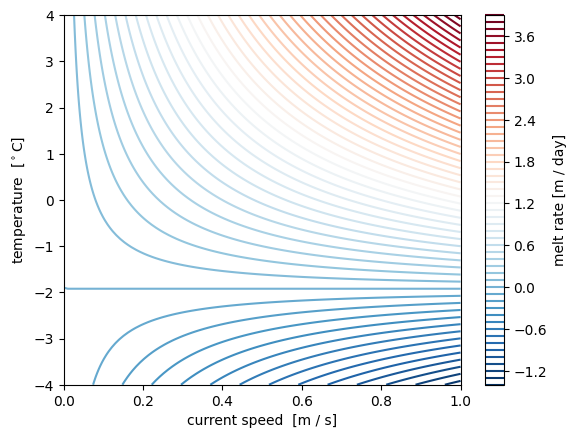

In [2]:
from icemeltmodels import TwoEquationMeltModel

S_w = 35 # g / kg
P_b = 0  # surface pressure
temperatures = np.linspace(-4, 4, 100)
speeds = np.linspace(0, 1, 100)
U, T_w = np.meshgrid(speeds, temperatures)
Z = TwoEquationMeltModel().melt_rate(U, T_w, S_w, P_b)
plt.contour(U, T_w, Z*(24*3600), 60, cmap="RdBu_r")
plt.colorbar(label="melt rate [m / day]")
plt.xlabel("current speed  [m / s]")
plt.ylabel(r"temperature  [$^\circ$C]");

## Three Equation Melt Model Neglecting Conduction

In this model, set $F_i=0$ as in the non-conducting two equation model, but we make a better approximation for the freezing temperature by estimating the salinity at the ice-ocean boundary using a salt conservation equation.
$$ \rho_i \dot{m} L_i = \rho_w c_w \gamma_T U (T_w - T_b) $$
$$ \rho_i \dot{m} S_b = \rho_w \gamma_S U (S_w - S_b) $$
$$ T_b = \lambda_1 S_w + \lambda_2 + \lambda_3 P_b, $$
The first equation is the heat conservation equation, the second equation the salt conservation equation, and the third equation is a linear approximation for the freezing temperature using the estimate of salinity at the boundary $S_b$ rather than the "ambient" salinity $S_w$ (we now call the freezing temperature $T_b$ to distinguish it from the earlier calculation).

The heat conservation has also changed: the transfer coefficient $\gamma_{TS}$ has been replaced by a heat transfer coefficient $\gamma_T$, and a corresponding salt transfer coefficient $\gamma_S$ is present in the salt conservation equation, which balances the salt that appears in the space that has just melted (loeft hand side) with the salt flux into that space from the turbulent boundary layer, parameterised in a similar way to the turbulent ocean heat flux in the heat conservation equation. The coefficients $\gamma_S$ and $\gamma_T$ were estimated from a fit to observations of basal melting of the Ronne Ice Shelf by Jenkins et al. (2010).

This system of equations produces a quadratic equation for $\dot{m}$
$$\frac{\rho_i^2 L_i}{\rho_w c_w \Gamma_T C_d^\frac{1}{2} U} \dot{m}^2 + \rho_i \left(\frac{L_i \Gamma_S}{c_w \Gamma_T} + \lambda_2 + \lambda_3P_b - T_w \right) \dot{m} + \rho_w \Gamma_S C_d^\frac{1}{2} U (\lambda_1 S_w + \lambda_2 + \lambda_3 P_b - T_w) = 0$$
which can be solved using the quadratic equation.

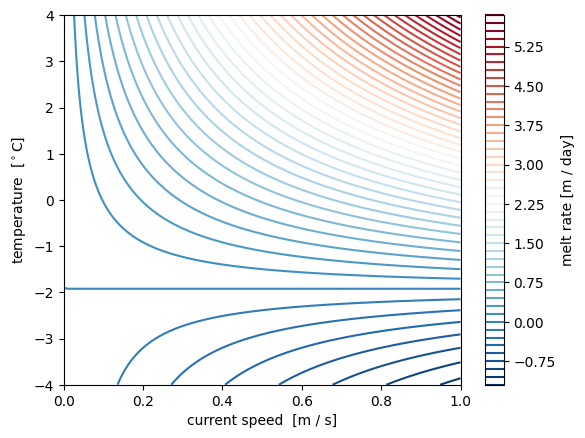

In [3]:
from icemeltmodels import ThreeEquationMeltModelNeglectingConduction

S_w = 35 # g / kg
P_b = 0  # surface pressure
temperatures = np.linspace(-4, 4, 100)
speeds = np.linspace(0, 1, 100)
U, T_w = np.meshgrid(speeds, temperatures)
Z = ThreeEquationMeltModelNeglectingConduction().melt_rate(U, T_w, S_w, P_b)
plt.contour(U, T_w, Z*(24*3600), 60, cmap="RdBu_r")
plt.colorbar(label="melt rate [m / day]")
plt.xlabel("current speed  [m / s]")
plt.ylabel(r"temperature  [$^\circ$C]");

## Three Equation Melt Model

This is the three equation model with the ice conduction term from the two equation model.

$$ \rho_i L_i \dot{m} = \rho_w c_w \gamma_{T} U (T_w - T_b) + \rho_i c_i (T_i - T_b) \dot{m}$$
$$ \rho_i S_b \dot{m} = \rho_w \gamma_S U (S_w - S_b) $$
$$ T_b = \lambda_1 S_b + \lambda_2 + \lambda_3 P_b. $$

Eliminating $T_b$ and $S_b$, this again gives a quadratic equation for $\dot{m}$:

$$ a \dot{m}^2 + b \dot{m} + c = 0 $$

with

$$a = \gamma + \delta \epsilon$$
$$b = \alpha \gamma - \beta T_w +\alpha \delta \lambda_1 S_w + \alpha \delta \epsilon + \beta \epsilon $$
$$c = -\alpha \beta T_w + \alpha \beta \lambda_1 S_w + \alpha \beta \epsilon $$

where
$$\alpha = \frac{\rho_w}{\rho_i} \Gamma_S C_d^\frac{1}{2} U$$
$$\beta = \rho_w c_w \Gamma_T C_d^\frac{1}{2} U$$
$$\gamma = \rho_i(L_i - c_i T_i)$$
$$\delta = \rho_i c_i$$
$$\epsilon = \lambda_2 + \lambda_3 P_b.$$

We take the positive root, so 
$$\dot{m} = \frac{-b + \sqrt{b^2 - 4ac}}{2a}$$

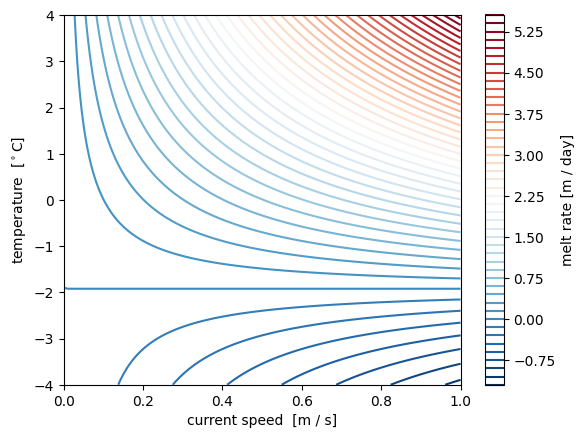

In [4]:
from icemeltmodels import ThreeEquationMeltModel

S_w = 35 # g / kg
P_b = 0  # surface pressure
temperatures = np.linspace(-4, 4, 100)
speeds = np.linspace(0, 1, 100)
U, T_w = np.meshgrid(speeds, temperatures)
Z = ThreeEquationMeltModel().melt_rate(U, T_w, S_w, P_b)
plt.contour(U, T_w, Z*(24*3600), 60, cmap="RdBu_r")
plt.colorbar(label="melt rate [m / day]")
plt.xlabel("current speed  [m / s]")
plt.ylabel(r"temperature  [$^\circ$C]");

## Comparing the four models

The plots below show the difference between the first three melt models and the last one (i.e. the melt rate predicted by the three equation model with conduction into the ice, subtracted from the melt rate predicted by each of the other three models) in the three panels except the bottom right one. The bottom right panel simply shows the melt rate predictions of the thee equation melt model.

We show below that the two equation melt models underestimate the melt rate at high temperatures and fast current speeds compared to the three equation model with conductive heat fluxes. 

Moreover, the three equation melt model neglecting conductive heat flux overestimates the melt rate compared to the three equation model that includes heat flux into the ice. This is because heat flux into the ice tends to carry away heat that would otherwise be used for melting (to overcome the latent heat energy barrier required for melting).

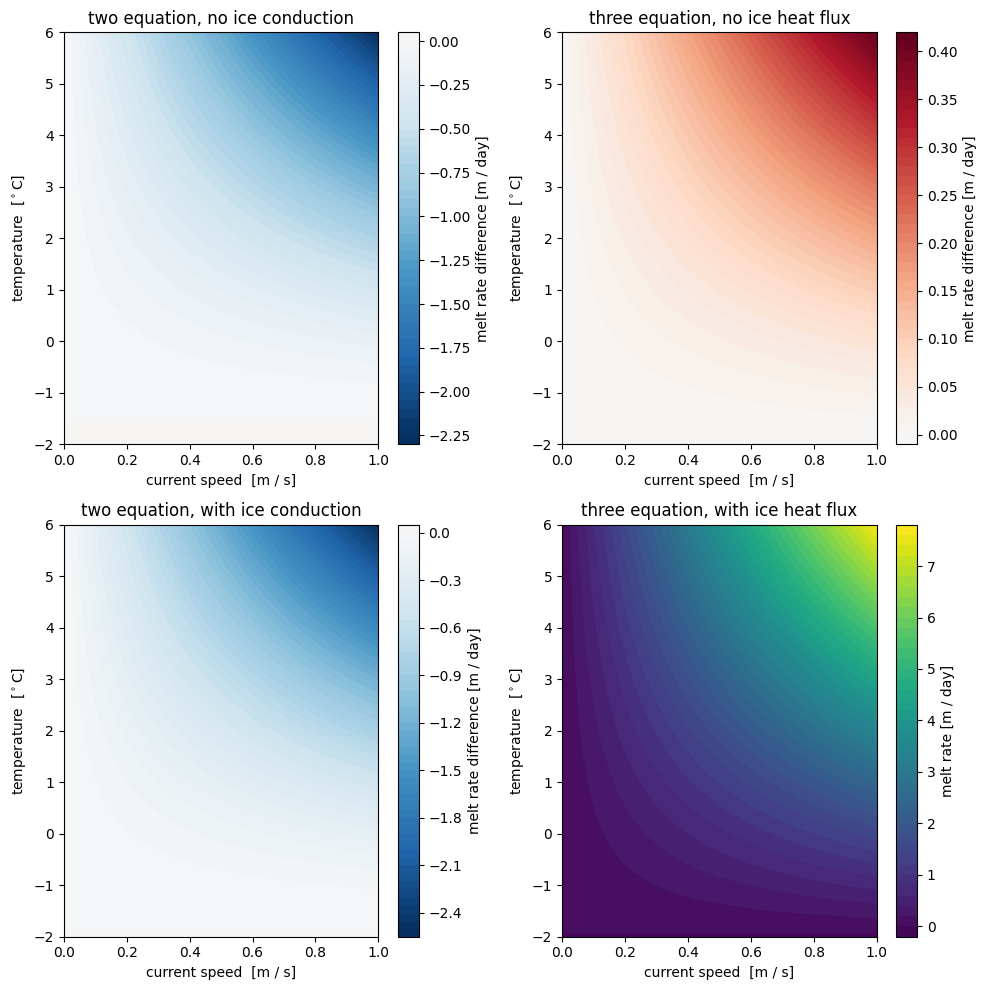

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

S_ref = 35
p_ref = 0

T = np.linspace(-2, 6, 100)
U = np.linspace(0, 1, 100)
X, Y = np.meshgrid(U, T)
Z0 = ThreeEquationMeltModel().melt_rate(X, Y, S_ref, p_ref)

Z = TwoEquationMeltModelNeglectingConduction().melt_rate(X, Y, S_ref, p_ref)
diff = (Z-Z0)*(24*3600)
vmax = np.max(np.abs(diff))
contour1 = ax[0][0].contourf(X, Y, diff, 50, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
plt.colorbar(contour1, ax=ax[0][0], label="melt rate difference [m / day]")
ax[0][0].set_xlabel("current speed  [m / s]")
ax[0][0].set_ylabel(r"temperature  [$^\circ$C]")
ax[0][0].set_title("two equation, no ice conduction")

Z = TwoEquationMeltModel().melt_rate(X, Y, S_ref, p_ref)
diff = (Z-Z0)*(24*3600)
vmax = np.max(np.abs(diff))
contour2 = ax[1][0].contourf(X, Y, diff, 50, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
plt.colorbar(contour2, ax=ax[1][0], label="melt rate difference [m / day]")
ax[1][0].set_xlabel("current speed  [m / s]")
ax[1][0].set_ylabel(r"temperature  [$^\circ$C]")
ax[1][0].set_title("two equation, with ice conduction")

Z = ThreeEquationMeltModelNeglectingConduction().melt_rate(X, Y, S_ref, p_ref)
diff = (Z-Z0)*(24*3600)
vmax = np.max(np.abs(diff))
contour3 = ax[0][1].contourf(X, Y, diff, 50, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
plt.colorbar(contour3, ax=ax[0][1], label="melt rate difference [m / day]")
ax[0][1].set_xlabel("current speed  [m / s]")
ax[0][1].set_ylabel(r"temperature  [$^\circ$C]")
ax[0][1].set_title("three equation, no ice heat flux")

contour4 = ax[1][1].contourf(X, Y, Z0*(24*3600), 50, cmap="viridis")
plt.colorbar(contour4, ax=ax[1][1], label="melt rate [m / day]")
ax[1][1].set_xlabel("current speed  [m / s]")
ax[1][1].set_ylabel(r"temperature  [$^\circ$C]")
ax[1][1].set_title("three equation, with ice heat flux")

plt.tight_layout()